## Загрузим данные тестового датасета

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("dataset.csv")

df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## Подсчет уникальных пользователей приложения

In [5]:
df["userid"].nunique()

90189

## Подсчет пользователей в каждой тестовой группе

In [4]:
df.groupby("version")[["userid"]].nunique()

,userid
version,
gate_30,44700
gate_40,45489


На основе полученных данных можно утверждать, что пользователи распределены между тестовыми группами поровну.

## Построим диаграмму распределения пользователей по количеству раундов

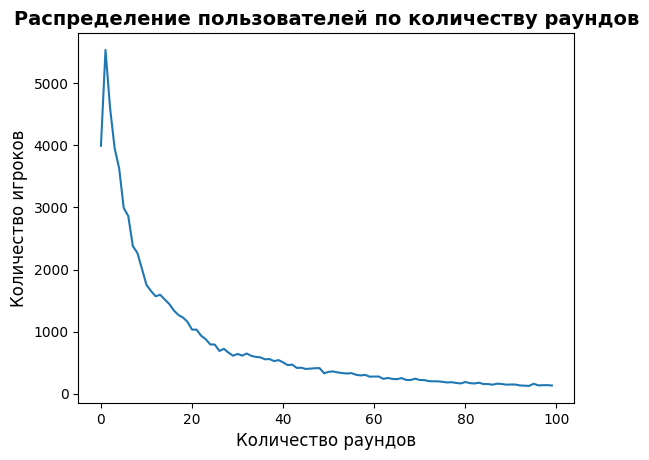

In [11]:
plot_df = df.groupby("sum_gamerounds")["userid"].count()

ax = plot_df.head(100).plot()
plt.title("Распределение пользователей по количеству раундов", fontweight="bold", size=14)
plt.xlabel("Количество раундов", size=12)
plt.ylabel("Количество игроков", size=12)
plt.show()


Диаграмма показывает, что около 4 тысяч пользователей вообще не играла в приложение после загрузки (0 раундов)

## Извлечем точное количество таких пользователей

In [7]:
df[df["sum_gamerounds"]== 0]["userid"].count()

3994

## Изучим статистику % удержанных пользователей (retention)

Retention — коэффициент удержания пользователей. Он показывает «возвращаемость» клиентов в приложение за определенный период после установки. Это одна из главных метрик мобильного маркетинга. Retention показывает, есть ли проблемы с вовлечением новых пользователей.

In [8]:
df_retention = df[["retention_1","retention_7"]].mean()*100
print(f"1-day retention ratio: {round(df_retention[0],2)}% \
      \n7-days retention ratio: {round(df_retention[1],2)}%")

1-day retention ratio: 44.52%       
7-days retention ratio: 18.61%


Таким образом получается, что почти половина пользователей (44,52%) не возвращается в игру после первого дня, и только 18% пользователей продолжают играть через 7 дней после загрузки приложения

## Проверим коээфициент удержания по разным тестовым группам

In [9]:
df_retention_ab = df.groupby("version").agg({"userid":"count", "retention_1":"mean","retention_7":"mean", "sum_gamerounds":"sum"})
df_retention_ab

,userid,retention_1,retention_7,sum_gamerounds
version,,,,
gate_30,44700,0.448188,0.190201,2344795
gate_40,45489,0.442283,0.182000,2333530


Представленная статистика показывает незначительное снижение показателя (retention) в тестовой группе gate_40 по сравнению с контрольной группой gate_30

## Проведем дополнительный анализ методом бутстрэпинга

Суть метода состоит в том, чтобы по имеющейся выборке построить эмпирическое распределение. Используя это распределение как теоретическое распределение вероятностей, можно с помощью датчика псевдослучайных чисел сгенерировать практически неограниченное количество псевдовыборок произвольного размера, например, того же, как у исходной. На множестве псевдовыборок можно оценить не только анализируемые статистические характеристики, но и изучить их вероятностные распределения. Таким образом, например, оказывается возможным оценить дисперсию или квантили любой статистики независимо от её сложности. Данный метод является методом непараметрической статистики.

Смоделируем таким образом расширенные результаты эксперимента на основе выборки 10 000 случайных наблюдений

Алгоритм:


- Выбираем наугад одно наблюдение из имеющихся.
- Повторяем пункт 1 столько раз, сколько у нас есть наблюдений. При этом некоторые из них мы выберем несколько раз, некотороые не выберем вообще — это нормально.
- Считаем интересующие нас метрики по этой новой выборке. Запоминаем результат.
- Повторяем пункты 1-3 много раз. Например, 10 тысяч. Можно меньше, но точность будет хуже. Можно больше, но долго будет считать.

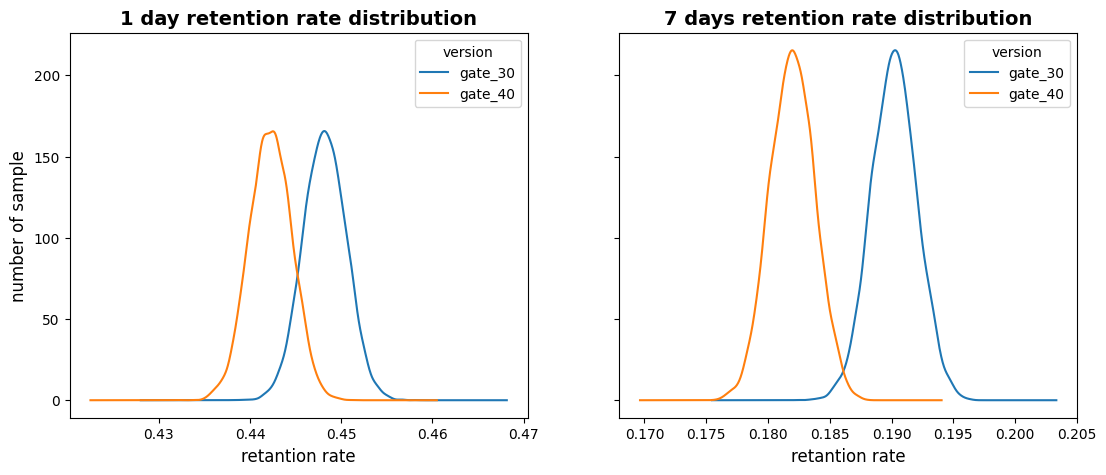

In [12]:
boot_1d = []
boot_7d = []
for i in range(10000):
    boot_mean_1 = df.sample(frac=1, replace=True).groupby('version')['retention_1'].mean()
    boot_mean_7 = df.sample(frac=1, replace=True).groupby('version')['retention_7'].mean()
    boot_1d.append(boot_mean_1)
    boot_7d.append(boot_mean_7)
    
boot_1d = pd.DataFrame(boot_1d)
boot_7d = pd.DataFrame(boot_7d)

fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(13,5))

boot_1d.plot.kde(ax=ax1)
ax1.set_xlabel("retantion rate",size=12)
ax1.set_ylabel("number of sample",size=12)
ax1.set_title("1 day retention rate distribution", fontweight="bold",size=14)

boot_7d.plot.kde(ax=ax2)
ax2.set_xlabel("retantion rate",size=12)
ax2.set_title("7 days retention rate distribution", fontweight="bold",size=14)
plt.show()

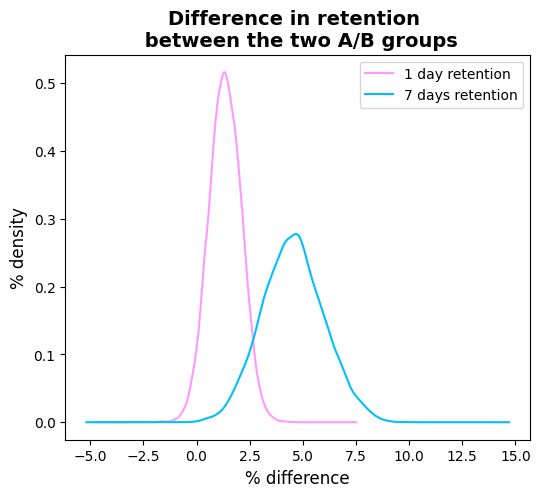

In [13]:
boot_1d['diff'] = ((boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40'] * 100)
boot_7d['diff'] = ((boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100)

fig, (ax1) = plt.subplots(1, 1,figsize=(6,5))

boot_1d['diff'].plot.kde(ax=ax1, c="#ff99ff", label = "1 day retention")
boot_7d['diff'].plot.kde(ax=ax1, c= "#00bfff", label = "7 days retention")
ax1.set_xlabel("% difference",size=12)
ax1.set_ylabel("% density",size=12)
ax1.set_title("Difference in retention \n between the two A/B groups", fontweight="bold", size=14)
plt.legend()
plt.show()

## Расчет вероятности того, что  показатель retention выше в версии gate_30

In [15]:
prob_1 = (boot_1d['diff']>0).sum()/len(boot_1d['diff'])

prob_7 = (boot_7d['diff']>0).sum()/len(boot_7d['diff'])

print(f"Вероятность того, что  показатель '1-day retention' выше в версии gate_30: {round(prob_1,2)*100}% \
      \nВероятность того, что  показатель '7-day retention' выше в версии gate_30: {(prob_7)*100}% ")

Вероятности того, что  показатель '1-day retention' выше в версии gate_30: 96.0%       
Вероятности того, что  показатель '7-day retention' выше в версии gate_30: 99.98% 


В рзультате анализа имеем убедительные доказательства того, что с вероятностью 99,98%  показатель 7-дневного удержания выше на версии gate_30, чем когда они находятся на версии 40.

Вывод таков: если мы хотим поддерживать высокий показатель удержания — как за 1, так и за 7 дней — нам не следует переводить пользователей на версию gate_40.